In [1]:
import pickle
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torch

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import torch
from sklearn.svm import SVC
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from utils import configs
import hashlib
sys.path.append("/home/zsarwar/Projects/SparseDNNs/adversarial-attacks-pytorch")
import torchattacks

from utils.utils_2 import imshow, get_pred
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import DataLoader, Subset
import numpy as np
from utils.rbf_model import RBF_SVM

In [4]:
import torch.nn as nn
import torch
import pickle


class RBF_SVM(nn.Module):
    def __init__(self, clf):
        super().__init__()
        self.SV = nn.Parameter(torch.from_numpy(clf.support_vectors_))
        self.IC = nn.Parameter(torch.tensor(clf.intercept_))
        self.DC = nn.Parameter(torch.from_numpy(clf.dual_coef_))
        self.gamma = nn.Parameter(torch.tensor(clf.gamma))
        self.SV.requires_grad = True
        self.IC.requires_grad = True
        self.DC.requires_grad = True
        self.gamma.requires_grad = True

    def forward(self, X):
        X_expanded = X.unsqueeze(1)
        SV_broadcasted = torch.broadcast_to(self.SV, (X.shape[0], self.SV.shape[0], self.SV.shape[1]))
        res_batch = torch.subtract(SV_broadcasted, X_expanded)
        res_batch = torch.norm(res_batch, p=2, dim=2)
        res_batch = torch.square(res_batch)
        res_batch = torch.multiply(-self.gamma, res_batch)
        res_batch = torch.exp(res_batch)
        res_batch = torch.multiply(res_batch, self.DC)
        res_batch = torch.sum(res_batch, dim=1)
        res_batch = res_batch + self.IC
        return res_batch


In [5]:
rbf_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/RBF/RBF_CW_5120_Regular.pkl"
with open(rbf_path,'rb') as in_model:
    clf = pickle.load(in_model)
    
# Class RBF model
rbf_svm = RBF_SVM(clf)

In [6]:
"""
def load_data(path, label):
    with open(path, 'rb') as iffile:
        features = pickle.load(iffile)
    layer = 'view'
    features = features[layer]
    features_matrix = None

    for i in range(len(features)):
        if isinstance(features_matrix, torch.Tensor):
            features_matrix = torch.cat((   features_matrix, features[i]))
        else:
            features_matrix = features[i]

    features = None    
    features_matrix = torch.flatten(features_matrix, start_dim=1, end_dim=-1)
    y = np.empty(features_matrix.shape[0])
    y.fill(label)
    return [features_matrix, y]
"""


def load_data(path, label):
    features_matrix = torch.load(path)
    y = np.empty(features_matrix.shape[0])
    y.fill(label)
    return [features_matrix, y]

def unison_shuffled_copies_ind(X, y):
    assert len(X) == len(y)
    p = np.random.permutation(len(X))
    return X[p], y[p]


def unison_shuffled_copies(x_ben, y_ben, x_adv, y_adv):
    X = np.concatenate((x_ben, x_adv), axis=0)
    y = np.concatenate((y_ben, y_adv), axis=0)
    assert len(X) == len(y)
    p = np.random.permutation(len(X))
    return X[p], y[p]


def get_paths(base_path):
    attack="CW"
    total_attack_samples = 5120
    integrated = False
    relu_dir = "ReLUs"
    detector_type='Regular'
    train_benign = f"ReLUs_{attack}_train_benign_{total_attack_samples}_detector-type-{detector_type}_integrated-{integrated}.pkl"
    train_adversarial = f"ReLUs_{attack}_train_adversarial_{total_attack_samples}_detector-type-{detector_type}_integrated-{integrated}.pkl"
    test_benign = f"ReLUs_{attack}_test_benign_{total_attack_samples}_detector-type-{detector_type}_integrated-{integrated}.pkl"
    test_adversarial = f"ReLUs_{attack}_test_adversarial_{total_attack_samples}_detector-type-{detector_type}_integrated-{integrated}.pkl"

    train_benign = os.path.join(base_path, relu_dir, train_benign)
    train_adversarial = os.path.join(base_path, relu_dir,  train_adversarial)
    test_benign = os.path.join(base_path,  relu_dir, test_benign)
    test_adversarial = os.path.join(base_path,  relu_dir, test_adversarial)

    all_paths = [train_benign,train_adversarial,test_benign,test_adversarial]

    return all_paths



In [32]:
#path2 = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/ReLUs/ReLUs_CW_test_adversarial_512_detector-type-Regular_integrated-True.pth"
#path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/ReLUs/ReLUs_CW_test_benign_512_detector-type-Regular_integrated-False.pkl"
path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/ReLUs/activations.pth"
#X2, y2 = load_data(path2, -1)
X, y = load_data(path, -1)

In [33]:
x_pred = clf.predict(X)
acc = len(np.where(x_pred == y)[0]) / len(X)
print("Accuracy : ", acc)
print("RBF tested...")



Accuracy :  0.251953125
RBF tested...


In [34]:
import pickle
with open("/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/Adversarial_Datasets/CW_adv_samples_512_test_detector-type-Regular_integrated-True.pickle", 'rb') as iffi:
    adv_images = pickle.load(iffi)

In [10]:
feats = torch.load("/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/ReLUs/ReLUs_CW_test_adversarial_512_detector-type-Regular_integrated-True.pth")

In [14]:
feats[0]

tensor([9.8591e-02, 2.4871e-02, 2.4430e-03, 1.9704e-02, 2.2680e-01, 9.7668e-02,
        8.1776e-01, 2.7111e-04, 0.0000e+00, 2.8677e-01, 3.6766e-02, 6.4051e-03,
        2.1870e-01, 8.8778e-03, 0.0000e+00, 9.9895e-02, 3.3468e-02, 4.3264e-02,
        1.4539e-01, 8.5985e-02, 3.9879e-02, 4.7777e-02, 1.0282e-01, 5.0694e-01,
        8.8367e-03, 2.8149e-01, 1.0308e-01, 5.5417e-02, 6.4430e-02, 1.6152e-02,
        1.3095e-04, 2.4005e-01, 3.2919e-01, 2.1300e-01, 1.2130e-01, 1.3937e-01,
        1.7947e+00, 4.6814e-02, 1.7062e-01, 1.1615e-02, 3.0147e-01, 3.0213e-01,
        3.2052e-02, 0.0000e+00, 4.1294e-01, 4.5042e-02, 2.7997e-01, 3.7986e-02,
        5.7363e-03, 1.6557e-01, 3.1226e-02, 4.2771e-03, 2.8256e-02, 5.3961e-02,
        3.4207e-02, 5.4275e-01, 2.1567e-04, 5.5861e-03, 7.3118e-01, 2.3739e-01,
        8.5634e-01, 1.8987e-02, 1.8099e-02, 1.2705e-01, 4.5058e-01, 3.7861e-01,
        1.9674e-02, 3.5807e-02, 2.6109e-03, 2.1615e-02, 4.1328e-02, 5.4974e-01,
        9.3865e-02, 9.9862e-04, 1.7049e-

In [35]:
adv_images[0][0]

tensor([[[0.7725, 0.7647, 0.7765,  ..., 0.8078, 0.8000, 0.8000],
         [0.7647, 0.7569, 0.7647,  ..., 0.7961, 0.7843, 0.7843],
         [0.7686, 0.7608, 0.7686,  ..., 0.7922, 0.7882, 0.7843],
         ...,
         [0.3647, 0.3294, 0.3333,  ..., 0.5059, 0.5176, 0.5412],
         [0.4510, 0.4510, 0.4471,  ..., 0.5216, 0.5373, 0.5490],
         [0.4706, 0.4667, 0.4588,  ..., 0.5294, 0.5373, 0.5451]],

        [[0.8431, 0.8392, 0.8471,  ..., 0.8627, 0.8706, 0.8706],
         [0.8353, 0.8275, 0.8314,  ..., 0.8510, 0.8549, 0.8549],
         [0.8392, 0.8314, 0.8353,  ..., 0.8510, 0.8549, 0.8549],
         ...,
         [0.3451, 0.2863, 0.2745,  ..., 0.5020, 0.5216, 0.5451],
         [0.4471, 0.4314, 0.4235,  ..., 0.5333, 0.5451, 0.5529],
         [0.4824, 0.4784, 0.4706,  ..., 0.5451, 0.5490, 0.5569]],

        [[0.9020, 0.8941, 0.9020,  ..., 0.9255, 0.9255, 0.9255],
         [0.8902, 0.8824, 0.8902,  ..., 0.9137, 0.9098, 0.9098],
         [0.8941, 0.8863, 0.8902,  ..., 0.9098, 0.9098, 0.

In [9]:
x_pred = clf.predict(X2)
acc = len(np.where(x_pred == y)[0]) / len(X2)
print("Accuracy : ", acc)
print("RBF tested...")



Accuracy :  0.791015625
RBF tested...


In [15]:
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()


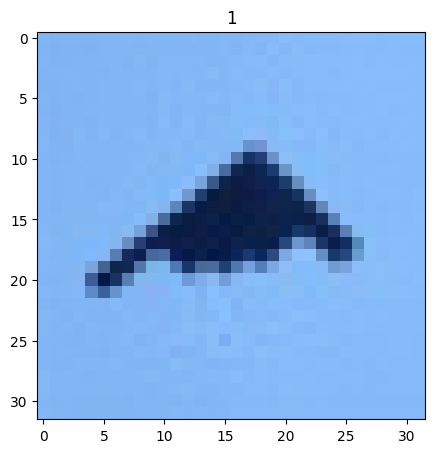

In [20]:
imshow(adv_images[0][222
                     ], title="1")

In [16]:
X[0].shape

torch.Size([640])

In [7]:
def quantize(X):
    X[0] = torch.where(X[0] > 0, torch.ones_like(X[0]), torch.zeros_like(X[0]))
    return X

In [8]:
expr_dir = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b"

train_benign,train_adversarial,test_benign,test_adversarial = get_paths(expr_dir)
train_benign = load_data(train_benign, 1)
train_adversarial = load_data(train_adversarial, -1)
test_benign = load_data(test_benign, 1)
test_adversarial = load_data(test_adversarial, -1)

train_benign = quantize(train_benign)
train_adversarial = quantize(train_adversarial)
test_benign = quantize(test_benign)
test_adversarial = quantize(test_adversarial)



In [9]:
X_train, y_train = unison_shuffled_copies(train_benign[0], train_benign[1], train_adversarial[0], train_adversarial[1])

X_test, y_test = unison_shuffled_copies(test_benign[0], test_benign[1], test_adversarial[0], test_adversarial[1])



In [10]:
clf = SVC(C=0.7, gamma=0.0075)
clf.fit(X_train, y_train)


SVC(C=0.7, gamma=0.0075)

In [11]:
# 0.075

# Testing
x_train_pred = clf.predict(X_train)
train_acc = len(np.where(x_train_pred == y_train)[0]) / len(X_train)

x_test_pred = clf.predict(X_test)
test_acc = len(np.where(x_test_pred == y_test)[0]) / len(X_test)



print(f"Training acc : {train_acc}")
print(f"Test acc : {test_acc}")

# Test classwise
x_train_ben_pred = clf.predict(train_benign[0])
train_ben_acc = len(np.where(x_train_ben_pred == train_benign[1])[0]) / len(x_train_ben_pred)

x_train_adv_pred = clf.predict(train_adversarial[0])
train_adv_acc = len(np.where(x_train_adv_pred == train_adversarial[1])[0]) / len(x_train_adv_pred)

x_test_ben_pred = clf.predict(test_benign[0])
test_ben_acc = len(np.where(x_test_ben_pred == test_benign[1])[0]) / len(x_test_ben_pred)

x_test_adv_pred = clf.predict(test_adversarial[0])
test_adv_acc = len(np.where(x_test_adv_pred == test_adversarial[1])[0]) / len(x_test_adv_pred)

print(f"Training benign acc : {train_ben_acc}")
print(f"Training adversarial acc : {train_adv_acc}")
print(f"-------------------------------------")
print(f"Testing benign acc : {test_ben_acc}")
print(f"Testing adversarial acc : {test_adv_acc}")



Training acc : 0.96171875
Test acc : 0.89658203125
Training benign acc : 0.9720703125
Training adversarial acc : 0.9513671875
-------------------------------------
Testing benign acc : 0.856640625
Testing adversarial acc : 0.9365234375


In [46]:
# 0.005

# Testing
x_train_pred = clf.predict(X_train)
train_acc = len(np.where(x_train_pred == y_train)[0]) / len(X_train)

x_test_pred = clf.predict(X_test)
test_acc = len(np.where(x_test_pred == y_test)[0]) / len(X_test)



print(f"Training acc : {train_acc}")
print(f"Test acc : {test_acc}")

# Test classwise
x_train_ben_pred = clf.predict(train_benign[0])
train_ben_acc = len(np.where(x_train_ben_pred == train_benign[1])[0]) / len(x_train_ben_pred)

x_train_adv_pred = clf.predict(train_adversarial[0])
train_adv_acc = len(np.where(x_train_adv_pred == train_adversarial[1])[0]) / len(x_train_adv_pred)

x_test_ben_pred = clf.predict(test_benign[0])
test_ben_acc = len(np.where(x_test_ben_pred == test_benign[1])[0]) / len(x_test_ben_pred)

x_test_adv_pred = clf.predict(test_adversarial[0])
test_adv_acc = len(np.where(x_test_adv_pred == test_adversarial[1])[0]) / len(x_test_adv_pred)

print(f"Training benign acc : {train_ben_acc}")
print(f"Training adversarial acc : {train_adv_acc}")
print(f"-------------------------------------")
print(f"Testing benign acc : {test_ben_acc}")
print(f"Testing adversarial acc : {test_adv_acc}")



Training acc : 0.9544921875
Test acc : 0.8935546875
Training benign acc : 0.9654296875
Training adversarial acc : 0.9435546875
-------------------------------------
Testing benign acc : 0.8552734375
Testing adversarial acc : 0.9318359375


In [27]:
# Quantize
# Comput per-dimension mean

In [ ]:
dim_mean = features_matrix.mean(dim=0)

In [ ]:
binarized_matrix = torch.where(features_matrix >= dim_mean, torch.ones_like(features_matrix), torch.zeros_like(features_matrix))

In [ ]:
features_matrix = None

In [ ]:

torch.cuda.empty_cache()

In [ ]:
binarized_matrix = binarized_matrix.cpu().numpy()